# Pseudo Labeling with QDA scores LB 0.969
Roman posted a kernel introducing pseudo labeling [here][1]. I would like to explain why it works, make a few improvements, and demonstrate the power of this technique! This kernel is the same as my support vector machine kernel [here][2] with QDA and pseudo labeling added. It achieves an impresive CV 0.970 and LB 0.969

In Santander's Customer Transaction competition, team Wizardry used pseudo labeling to increase their private LB by 0.0005 allowing them to beat second place by 0.0002 for the $25,000 prize! [here][3]

In "Instant Gratification" competition, we are building 512 models where each model's train data has approximately 512 rows and 40 columns. With 40 variables, a quadratic model would like more rows. With pseudo labeling, we can get an additional 400 rows of training data and increase CV and LB by 0.005!

[1]: https://www.kaggle.com/nroman/i-m-overfitting-and-i-know-it/notebook
[2]: https://www.kaggle.com/cdeotte/support-vector-machine-0-925
[3]: https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89003

# What is Pseudo Labeling?
Pseudo labeling is the process of adding confident predicted test data to your training data. Pseudo labeling is a 5 step process. (1) Build a model using training data. (2) Predict labels for an unseen test dataset. (3) Add confident predicted test observations to our training data (4) Build a new model using combined data. And (5) use your new model to predict the test data and submit to Kaggle. Here is a pictorial explanation using sythetic 2D data. 
  
## Step 1 - Build first model
Given 50 training observations (25 target=1 yellow points, 25 target=0 blue points) build a model using QDA. Notice how QDA calculates the two multivariate Gaussian distributions that the target=1 and target=0 were drawn from. QDA's approximation is represented as ellipses of 1, 2, 3 standard deviations for each distribution.
![image](http://playagricola.com/Kaggle/p16419.png)

## Step 2 - Predict test data
Using our model (ellipses), predict the target of 50 unknown data points. The bottom picture shows the decisions made by our classifier.
![image](http://playagricola.com/Kaggle/p26419.png)

![image](http://playagricola.com/Kaggle/p36419.png)

## Step 3 and 4 - Add pseudo label data and build second model
Add all predictions with `Pr(y=1|x)>0.99` and `Pr(y=0|x)>0.99` to our training data. Then train a new model using the combined 90 points with QDA. The red ellipses show QDA's new approximation of the two Gaussian distributions. This time QDA has found better ellipses then before.

![image](http://playagricola.com/Kaggle/p46419.png)

## Step 5 - Predict test data
Finally use our more accurate QDA ellipses to predict test (a second time) and submit to Kaggle.

# Why does Pseudo Labeling work?
When I first learned about pseudo labeling (from team Wizardry's 1st place solution [here][1]), I was surprised that it could increase a model's accuracy. How does training with unknown data that has been labeled by a model improve that same model? Doesn't the model already know the information? Because the model made those predictions.

How pseudo labeling works is best understood with QDA. QDA works by using points in p-dimensional space to find hyper-ellipsoids, see [here][2]. With more points, QDA can better estimate the center and shape of each ellipsoid (and consequently make better preditions afterward).

Pseudo labeling helps all types of models because all models can be visualized as finding shapes of target=1 and target=0 in p-dimensional space. See [here][3] for examples. More points allow for better estimation of shapes.

[1]: https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89003
[2]: https://www.kaggle.com/c/instant-gratification/discussion/93843
[3]: https://www.kaggle.com/c/instant-gratification/discussion/94179

# Apply Pseudo Labeling to Instant Gratification Comp
## Load Data

In [1]:
import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

# Step 1 and 2 - Build first QDA model and predict test

In [2]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
       
    #if i%64==0: print(i)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('QDA scores CV =',round(auc,5))

QDA scores CV = 0.96541


# Step 3 & 4 - Add pseudo label data and build second model 

In [3]:
# INITIALIZE VARIABLES
test['target'] = preds
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for k in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    
    # ADD PSEUDO LABELED DATA
    test2p = test2[ (test2['target']<=0.01) | (test2['target']>=0.99) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof
        
        # MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
        preds[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits
       
    #if k%64==0: print(k)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('Pseudo Labeled QDA scores CV =',round(auc,5))

Pseudo Labeled QDA scores CV = 0.97033


# Submit Predictions

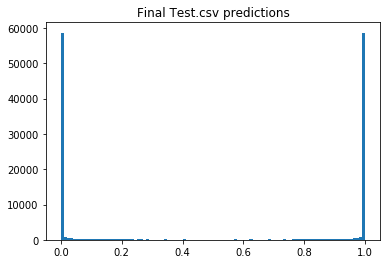

In [4]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()

# Conclusion
In this kernel, we learned what pseudo labeling is, why it works, and how to deploy it. Using it on the data from Instant Gratification competition we observed it increase CV by an impressive 0.005! Pseudo labeling QDA achieved CV 0.970 and LB 0.969. Without pseudo labeling, QDA achieved CV 0.965 and LB 0.965.

When you run your kernel locally, it will only pseudo label the public test data (because that is all that `test.csv` contains). When you submit this solution to Kaggle, your submission will load the full `test.csv` and pseudo label both the public and private test data set. Thus you will approximately double your amount of training data for your submissions!